# Lockdown baking - part 2

A project for scraping and analysing data from reddit (r/Sourdough) to explore baking trends during 2020.

Part 2: Data cleaning and analysis

# Setup

In [2]:
## set root folder
import os 
os.chdir("..")

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import calplot #to make calendar heat map

%matplotlib inline

# Clean data

## Load data

In [91]:
#load scraped datafiles
df = pd.read_csv(".\\data\scraped\post_df_2021-01-07.csv")

In [92]:
# explore shape and columns
print(df.shape)
print(df.columns)
print("")
print(df.head(3))

(41309, 8)
Index(['Unnamed: 0', 'id', 'score', 'created_utc', 'title', 'num_comments',
       'can_mod_post', 'author'],
      dtype='object')

   Unnamed: 0      id  score  created_utc  \
0           0  eibhvl      1   1577839131   
1           1  eibvur      1   1577841129   
2           2  eiby7m      1   1577841483   

                                               title  num_comments  \
0  First attempt at a starter, really hope I mana...             5   
1  Skillet &amp; Dutch Oven Sourdough in the rain...             0   
2  My last bread of 2019. I used Brad and Claire’...             0   

   can_mod_post         author  
0         False  coentertainer  
1         False     Richness69  
2         False     canioli019  


## Remove unnecessary data

In [93]:
print(df["can_mod_post"].value_counts()) 

#since there are no moderators, we don't need this variable
df = df.drop(columns=["can_mod_post"])

#check if column has been removed correctly
print(df.columns)

False    41309
Name: can_mod_post, dtype: int64
Index(['Unnamed: 0', 'id', 'score', 'created_utc', 'title', 'num_comments',
       'author'],
      dtype='object')


## Derive date and time variables

In [94]:
from datetime import datetime

# derive datetime from unix timestamp
df["created"] = pd.to_datetime(df["created_utc"], unit = 's')

#derive month from datetime
df["created_month"] = pd.DatetimeIndex(df["created"]).month
df["created_month_label"] = df["created_month"].map({1: "January", 2: "February", 3:"March", 4:"April", 5:"May",
                                                    6:"June", 7:"July", 8:"August", 9:"September", 10:"October",
                                                    11:"November", 12: "December"})

#derive day from datetime
df["created_short"] = df.created.dt.strftime("%Y-%m-%d")

#derive weekday from datetime
weekday_map = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3:"Thursday", 4: "Friday", 5:"Saturday", 6:"Sunday"}
df["created_weekday"] = pd.DatetimeIndex(df["created"]).weekday

#derive hour from datetime
df["created_hour"] = pd.DatetimeIndex(df["created"]).hour

#derive week number from datetime
df["created_week"] = pd.DatetimeIndex(df["created"]).week

## Title

We need to clean the text data in the title so that we can do some proper text mining. This includes

- Standardising
- Tokenising and removing stop words
- Lemmatising





### Standardising

We will remove punctuation and clean any other symbols/words as needed.

In [95]:
# make titles lower case
title = df["title"].str.lower()

# replace values within titles

# function to loop through the column and replace substrings
def replace_values(text, dic):
    for x, y in dic.items():
        text = text.str.replace(x, y, regex=True)
    return text

# list of values to be replaced, including punctuation
replace_dict = {"&amp;": " ", #xml syntax for &
                "[!\"#$%&()*+,./:;<=>?@[\]^_`{|}~“”-]": " ",
                "pnw" : "pacific northwest",
                "  ": " ", #double space
                "’s" :"",  
                "’m" : "",
                "y'all": "you all",
                "i'm": "i am",
                "i've": "i have",
                "it'll": "it will",
                "we're": "we are",
                "i'd": "i would",
                "loaves": "loaf"
               }
                
# apply function
title = replace_values(title, replace_dict)

# strip white space at the end
title = title.str.strip()

# add new column to dataframe
df["title_standardised"] = title

print(title)

0        first attempt at a starter  really hope i mana...
1        skillet  amp  dutch oven sourdough in the rain...
2        my last bread of 2019  i used brad and claire ...
3        i started baking in september and i have never...
4                                          sourdough books
5                                      analyzing sourdough
6        ginger tumeric loaf to guide me out of the decade
7        behold bread majors  he will incite the rocky ...
8                                    last loaf of the year
9                       wheat flour starter vs rye starter
10                  my sourdough starter smells like vomit
11              achieved a number of firsts with this bake
12       the wheat loaf i made for my family 2 hours be...
13                                                   hooch
14                     i so happy with how this turned out
15             third attempt  much happier with the result
16       new years eve loaf  2nd time ever baking and t.

### Remove stop words

We now remove stop words that don't really help to identify the sentiment or topic of a sentence. 

In [96]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [97]:
# create empty list to store titles without stop words
title_no_stop_words = []

# iterate through each word in each title and append those that are no stop words
# split titles into substrings using space as delimiter
for words in title.str.split(" "):
    x = []
    for word in words:
        if word not in stop_words:
            x.append(word)
    title_no_stop_words.append(x)

# join titles back together
title_no_stop_words = [" ".join(items) for items in title_no_stop_words]

# add title to dataframe
df["title_no_stop_words"] = title_no_stop_words

print(title_no_stop_words[:10])

['first attempt starter  really hope manage keep alive  mixed existence opening second decade', 'skillet  amp  dutch oven sourdough rainy pacific northwest', 'last bread 2019  used brad claire recipe alive  sourdough starter smelled bit sweet weird bread turned good anyways', 'started baking september never happier decision  may new year bring happy starters crackly crusts', 'sourdough books', 'analyzing sourdough', 'ginger tumeric loaf guide decade', 'behold bread majors  incite rocky horror sourdough', 'last loaf year', 'wheat flour starter vs rye starter']


### Lemmatize
Now we want to reduce the inflectional forms of each word into a common base or root. We do this by using a lemmatiser that detects the lemma for each word. 

Read [this article](https://blog.bitext.com/what-is-the-difference-between-stemming-and-lemmatization/) for more information on the difference betweent stemmatising and lemmatising. 

You will need to install spacy and download the en_core_web_sm package. Explanation [here](https://spacy.io/usage).

In [101]:
import en_core_web_sm

# load model from SpaCy
nlp = en_core_web_sm.load()

# create new list to store lemmatised titles
title_lemmatised = []

# iterate through each word in each title and append the lemmatised version of the word
for words in pd.Series(title_no_stop_words):
    x = []
    for word in nlp(words):
        x.append(word.lemma_)
    title_lemmatised.append(x)

# join titles back together
title_lemmatised = [" ".join(items) for items in title_lemmatised]

df["title_lemmatised"] = title_lemmatised

## Remove duplicates

In [102]:
# detect duplicates based on author and title standardised
print("Number of duplicate rows: ",len(df[df[["author", "title_standardised"]].duplicated(keep="last")]))

#remove duplicates and reset index
df = df.drop_duplicates(subset=["author", "title_standardised"],keep="last").reset_index(drop=True) #data ordered by date, last = latest
print("New number of rows: ", len(df))

Number of duplicate rows:  783
New number of rows:  40526


## User group

In [105]:
# count number of posts by author and put them into groups
bins = [0, 1, 2, 5, 10, 50, np.inf]
bin_labels = ["1", "2", "3-5", "6-10", "11-50","Over 50"]

pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot['posts_by_user'] = pd.cut(pivot['id'], bins, labels=bin_labels)
pivot = pivot.reset_index().drop(columns="id")

# add column to dataframe based on number of posts by author as 'user group'
df = pd.merge(df, pivot, left_on="author", right_on="author", how='left')

#print head
df.head()

,Unnamed: 0,id,score,created_utc,title,num_comments,author,created,created_month,created_month_label,created_short,created_weekday,created_hour,created_week,title_standardised,title_no_stop_words,title_lemmatised,posts_by_user
0,0,eibhvl,1,1577839131,"First attempt at a starter, really hope I mana...",5,coentertainer,2020-01-01 00:38:51,1,January,2020-01-01,2,0,1,first attempt at a starter really hope i mana...,first attempt starter really hope manage keep...,first attempt starter really hope manage kee...,1
1,1,eibvur,1,1577841129,Skillet &amp; Dutch Oven Sourdough in the rain...,0,Richness69,2020-01-01 01:12:09,1,January,2020-01-01,2,1,1,skillet amp dutch oven sourdough in the rain...,skillet amp dutch oven sourdough rainy pacif...,skillet amp dutch oven sourdough rainy pac...,1
2,2,eiby7m,1,1577841483,My last bread of 2019. I used Brad and Claire’...,0,canioli019,2020-01-01 01:18:03,1,January,2020-01-01,2,1,1,my last bread of 2019 i used brad and claire ...,last bread 2019 used brad claire recipe alive...,last bread 2019 use brad claire recipe alive...,2
3,3,eictkk,1,1577846281,I started baking in September and I have never...,0,singular-chip,2020-01-01 02:38:01,1,January,2020-01-01,2,2,1,i started baking in september and i have never...,started baking september never happier decisio...,start bake september never happy decision ma...,6-10
4,4,eidmqm,1,1577851082,Sourdough Books,3,TheNightBaker97,2020-01-01 03:58:02,1,January,2020-01-01,2,3,1,sourdough books,sourdough books,sourdough book,2


## Moderator

In [106]:
##create column to identify moderators (those that have posted weekly discussion questions)
df["moderator"] = 0
df.loc[df["author"] == "phil_s_stein", "moderator"] = 1
df.loc[df["author"] == "AutoModerator", "moderator"] = 1

## Export cleaned dataframe

In [107]:
#save cleaned datafile
df.to_csv(".\\data\processed\df-for-analysis_2021-02-21.csv", index=False)

## Load clean datafile

In [65]:
## load processed data file
df = pd.read_csv(".\\data\processed\df-for-analysis_2021-02-21.csv")

# Analysis

## Filter

In [109]:
# create filters you might want to use later
mod_filter = (df["moderator"]==0)

## Engagement over time

In [110]:
## Submissions and comments by month
pivot = df.groupby("created_month")[["id", "num_comments", "author"]].agg({"id": "count",
                                                                             "num_comments":"sum",
                                                                            "author": "nunique"})
pivot.loc['Total'] = [df["id"].count(), df["num_comments"].sum(), df["author"].nunique()] #add total row
pivot

,num_comments,id,author
created_month,,,
1,9273,1560,1024
2,8046,1586,1023
3,14415,3253,2155
4,31076,7457,4739
5,30804,6923,4293
6,22387,4496,2780
7,20077,3558,2285
8,13000,2860,1846
9,10066,2090,1440


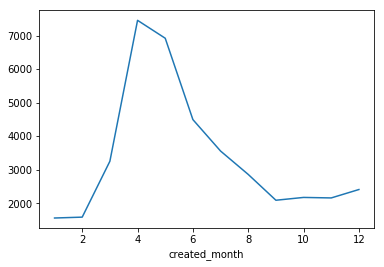

In [111]:
df.groupby("created_month")["id"].count().plot(kind='line')

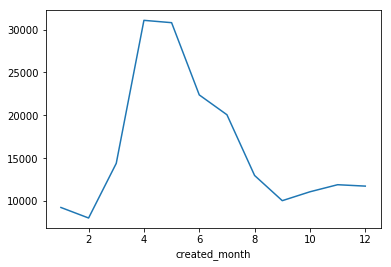

In [112]:
df.groupby("created_month")["num_comments"].sum().plot(kind='line')

### Summary by weekday

In [113]:
## Submissions and comments by weekday
pivot = df.groupby("created_weekday")[["id", "num_comments", "author"]].agg({"id": "count",
                                                                             "num_comments":"sum",
                                                                            "author": "nunique"})

pivot.loc['Total'] = [df["id"].count(), df["num_comments"].sum(), df["author"].nunique()] #add total row
pivot

,num_comments,id,author
created_weekday,,,
0,26317,5956,4331
1,29306,5349,4012
2,29137,5498,4059
3,26702,5203,3881
4,26865,5153,3927
5,26665,6100,4311
6,28940,7267,4945
Total,40526,193932,16865


### summary by month

In [114]:
df2 = df[["created_month", "created_month_label", "author", "num_comments"]]

df2 = df2.groupby('created_month', as_index=True).agg({'created_month_label': 'first',
                                                       'author': ["nunique", 'count'],
                                                       'num_comments': ['sum', 'max'] 
                                                      })
df2.columns = df2.columns.droplevel(level=0)
df2 = df2.reset_index().rename(columns={"created_month":"month", 
                                        "nunique":"unique_user", 
                                        "count": "no_of_submissions", 
                                        "sum":"total_comments",
                                       "max": "max_comments",
                                       "first": "month_label"})

# create metrics per user
df2["submission_per_user"] = df2["no_of_submissions"] / df2["unique_user"] 
df2["comments_per_submission"] = df2["total_comments"] / df2["no_of_submissions"] 

#save output
df2.to_csv(".\\data\charts\overview_by_month.csv", index=False)

df2

,month,unique_user,no_of_submissions,total_comments,max_comments,month_label,submission_per_user,comments_per_submission
0,1,1024,1560,9273,112,January,1.523438,5.944231
1,2,1023,1586,8046,63,February,1.550342,5.073140
2,3,2155,3253,14415,143,March,1.509513,4.431294
3,4,4739,7457,31076,951,April,1.573539,4.167360
4,5,4293,6923,30804,955,May,1.612625,4.449516
5,6,2780,4496,22387,619,June,1.617266,4.979315
6,7,2285,3558,20077,619,July,1.557112,5.642777
7,8,1846,2860,13000,216,August,1.549296,4.545455
8,9,1440,2090,10066,204,September,1.451389,4.816268
9,10,1474,2174,11101,199,October,1.474898,5.106256


## Calendar heatmap

Using [calplot](https://calplot.readthedocs.io/en/latest/). 

(<Figure size 900x122.4 with 2 Axes>,
 array([<AxesSubplot:ylabel='2020'>], dtype=object))

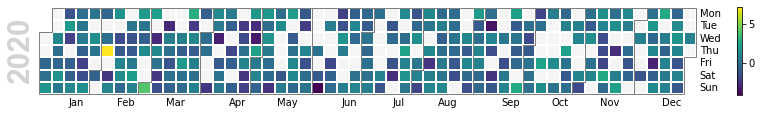

In [14]:
# example code
import calplot
import numpy as np; np.random.seed(sum(map(ord, 'calplot')))


all_days = pd.date_range('1/1/2020', periods=365, freq='D')
days = np.random.choice(all_days, 500)
events = pd.Series(np.random.randn(len(days)), index=days)
calplot.calplot(events)

### Comments

array([<AxesSubplot:ylabel='2020'>], dtype=object)

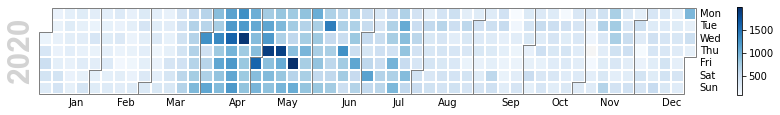

In [22]:
all_days = pd.date_range('1/1/2020', periods=366, freq='D')
events = df.groupby("created_short")["num_comments"].sum()
events = pd.Series(events, index=all_days)
fig = calplot.calplot(events, cmap='Blues')

fig[1]

<AxesSubplot:xlabel='created_month'>

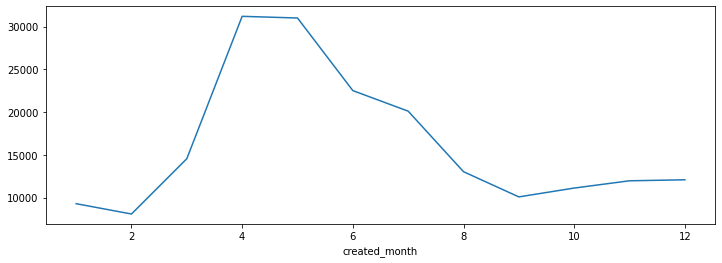

In [59]:
df.groupby("created_month")["num_comments"].sum().plot(kind='line', figsize=(12,4))

### Submissions

array([<AxesSubplot:ylabel='2020'>], dtype=object)

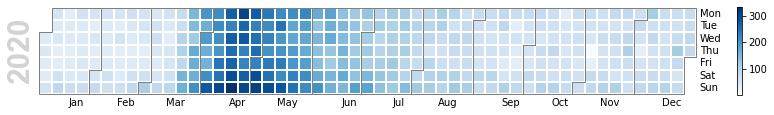

In [23]:
all_days = pd.date_range('1/1/2020', periods=366, freq='D')
events = df.groupby("created_short")["id"].count()
events = pd.Series(events, index=all_days)
fig = calplot.calplot(events, cmap='Blues')

fig[1]

<AxesSubplot:xlabel='created_month'>

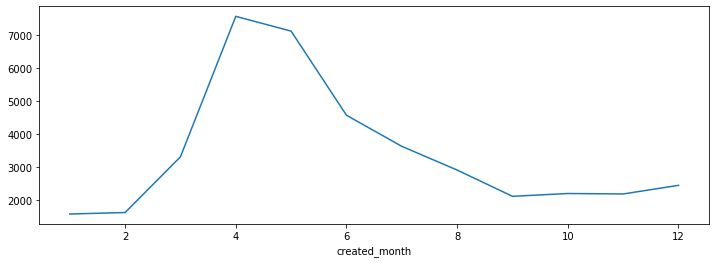

In [57]:
df.groupby("created_month")["id"].count().plot(kind='line', figsize=(12,4))

## Comments

In [115]:
df["num_comments"].median()

2.0

In [116]:
# number of posts with no comments

df.loc[df["num_comments"]==0]["num_comments"].value_counts() / len(df) *100

0    30.005429
Name: num_comments, dtype: float64

In [117]:
#look at posts with highest number of comments
comments = df[["title_lemmatised", "created_month_label", "num_comments", "author"]].sort_values(by="num_comments", ascending=False).head(30)

#save output
comments.to_csv(".//data/charts/top30-posts-by-comments.csv", index=False)

#display
comments

,title_lemmatised,created_month_label,num_comments,author
18838,weekly open sourdough question discussion post...,May,955,phil_s_stein
11680,open sourdough question discussion post apr...,April,951,phil_s_stein
15449,open sourdough question discussion post may...,May,945,phil_s_stein
17153,weekly open sourdough question discussion post...,May,881,phil_s_stein
14003,open sourdough question discussion post may...,May,821,phil_s_stein
22157,weekly open sourdough question discussion post...,June,619,phil_s_stein
25730,weekly open sourdough question discussion post...,July,619,phil_s_stein
9690,general r sourdough discussion post april...,April,525,phil_s_stein
20863,weekly open sourdough question discussion post...,June,494,phil_s_stein
23514,weekly open sourdough question discussion post...,June,474,phil_s_stein


In [119]:
#look at posts with highest number of comments excluding moderators
comments = df.loc[mod_filter][["title", "created_month_label", "num_comments", "author"]].sort_values(by="num_comments", ascending=False).head(30)

#save output
comments.to_csv(".//data/charts/top30-posts-by-comments-without-moderator.csv", index=False)

#display
comments

,title,created_month_label,num_comments,author
40202,Starter name sharing time I’ll start,December,356,kagadee
18806,"Unpopular Opinion: if you like your crumb, it'...",May,265,UnicornToots
28644,I made a sourdough baking app!,July,261,jscalo
21454,Just a video of le me shaping a 92% hydration ...,June,233,the_bread_code
27761,I’m enjoying bread making so much that I’ve ap...,July,220,ChickenBunch
18055,Here’s another video of me shaping sourdough. ...,May,216,delphinethebaker
21792,Guinness stouterdough bread. 100% of water sub...,June,193,BeardBeardBabyDunDun
28186,"Contrary to popular belief, it's entirely poss...",July,187,kaspervb99
37104,"The oven spring, the crumb, just mwah👌",November,187,PMme_slave_leia_pics
11486,I almost cried earlier today,April,183,Lt_DansNewLegs


### Number of comments by type of user

In [120]:
pivot = df.loc[df["moderator"]==0].groupby(["posts_by_user"]).agg({'num_comments': ["sum", "mean", "max"]})
pivot

num_comments               
                       sum      mean  max
posts_by_user                            
1                    38156  3.972928  356
2                    28125  4.445937  173
3-5                  46638  4.496096  216
6-10                 31132  4.750801  187
11-50                33302  5.163101  265
Over 50               4463  3.791844  233

## Number of users

### overview

In [121]:
df2 = df[["created_month", "author", "num_comments"]]

df2 = df2.groupby('created_month', as_index=True).agg({'author': [pd.Series.nunique, 'count'],
                                                                               'num_comments': ['sum']})
df2.columns = df2.columns.droplevel(level=0)
df2 = df2.reset_index()
df2 = df2.rename(columns={"created_month":"month", "nunique":"unique_user", "count": "no_of_submissions", "sum":"total_comments"})
df2["submission_per_user"] = df2["no_of_submissions"] / df2["unique_user"] 
df2["comments_per_submission"] = df2["total_comments"] / df2["no_of_submissions"] 

#load scraped datafiles
df2.to_csv(".\\data\charts\overview_by_month.csv", index=False)

df2

,month,unique_user,no_of_submissions,total_comments,submission_per_user,comments_per_submission
0,1,1024,1560,9273,1.523438,5.944231
1,2,1023,1586,8046,1.550342,5.073140
2,3,2155,3253,14415,1.509513,4.431294
3,4,4739,7457,31076,1.573539,4.167360
4,5,4293,6923,30804,1.612625,4.449516
5,6,2780,4496,22387,1.617266,4.979315
6,7,2285,3558,20077,1.557112,5.642777
7,8,1846,2860,13000,1.549296,4.545455
8,9,1440,2090,10066,1.451389,4.816268
9,10,1474,2174,11101,1.474898,5.106256


### number of submissions by user

On average, users submitted only 1 post, this is true for more than half of users. Two thirds have submitted at least 2 posts. On the top range, there is one user with 618 submissions which is now been deleted and 

In [122]:
pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot["id"].describe()

count    16865.000000
mean         2.402965
std          5.532697
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        576.000000
Name: id, dtype: float64

In [123]:
bins = [0, 1, 2, 5, 10 ,50, np.inf]
bin_labels = ["1", "2", "3-5", "6-10", "11-50","Over 50"]

pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot['users_by_posts'] = pd.cut(pivot['id'], bins, labels=bin_labels)
pivot = pd.DataFrame(pivot["users_by_posts"].value_counts()).reset_index()
pivot["user_by_posts_perc"] = pivot["users_by_posts"] / pivot["users_by_posts"].sum() *100

# save output
pivot.to_csv(".\\data\charts\posts_by_user_bins.csv", index=False)

pivot

,index,users_by_posts,user_by_posts_perc
0,1,9604,56.946339
1,2,3163,18.754818
2,3-5,2822,16.732879
3,6-10,889,5.271272
4,11-50,376,2.229469
5,Over 50,11,0.065224


### Users with more than 50 submissions

In [124]:
# check users with the highest number of posts
df.loc[df["posts_by_user"]=="Over 50"]["author"].unique()

array(['Pmcdonald16', 'oilologist', '[deleted]', 'Redrockcod', 'flrflzy',
       'the_bread_code', 'BeardBeardBabyDunDun', 'sigh_zip', 'michaelcgk',
       'ruffneckred', 'Breadtales'], dtype=object)

In [125]:
pivot = pd.DataFrame(df.groupby("author")["id"].count())
pivot = pivot.sort_values(by="id", ascending=False)
pivot.head(11)

,id
author,
[deleted],576
the_bread_code,78
Pmcdonald16,71
ruffneckred,60
Redrockcod,59
michaelcgk,58
oilologist,58
BeardBeardBabyDunDun,57
sigh_zip,55


### Engagement for users over time

In [50]:
# explore submissions by user group in each month

# Get pivot table
engagement = pd.DataFrame(df.groupby(["created_month", "posts_by_user"])["id"].count()).unstack()
engagement.columns = engagement.columns.droplevel()
engagement = engagement.reset_index()

# save output
engagement.to_csv(".//data/charts/number-of-users-by-type-over-time.csv", index=False)
print(engagement)

# calculate as percentage and save output
engagement_perc = engagement.set_index("created_month").transpose()
engagement_perc = (engagement_perc / engagement_perc.sum()*100).transpose()
engagement_perc.to_csv(".//data/charts/number-of-users-by-type-over-time-percent.csv", index=False)
print(engagement_perc) 

posts_by_user  created_month     1  11-50     2   3-5  6-10  Over 50
0                          1   388    180   250   432   261       49
1                          2   313    258   226   444   305       40
2                          3   849    474   525   839   499       66
3                          4  2175    834  1331  1885   993      238
4                          5  1720   1021  1115  1745  1144      177
5                          6   911    783   642  1171   759      229
6                          7   728    642   494   894   668      132
7                          8   572    580   409   712   539       45
8                          9   432    422   332   509   332       61
9                         10   437    452   340   571   333       40
10                        11   470    403   310   574   347       55
11                        12   610    431   354   587   382       45
posts_by_user          1      11-50          2        3-5       6-10   Over 50
created_month           

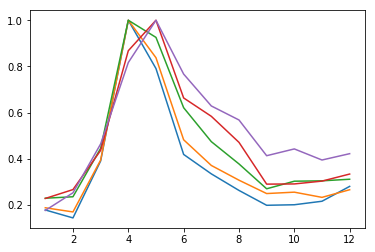

In [48]:
# draw number of users by number of posts on one chart --> normalise first

# normalise columns to put on one chart
# apply the maximum absolute scaling in Pandas using the .abs() and .max() methods
def maximum_absolute_scaling(df, columns):
    # copy the dataframe
    df_scaled = df.copy()
    # apply maximum absolute scaling
    for column in columns:
        df_scaled[column] = df_scaled[column]  / df_scaled[column].abs().max()
    return df_scaled
    
# call the maximum_absolute_scaling function
engagement_scaled = maximum_absolute_scaling(engagement, engagement.columns[1:])


# plot lines
x = engagement_scaled["created_month"]

plt.plot(x, engagement_scaled["1"], label = "line 1", linestyle="-") 
plt.plot(x, engagement_scaled["2"], label = "line 2", linestyle="-") 
plt.plot(x, engagement_scaled["3-5"], label = "line 3", linestyle="-")
plt.plot(x, engagement_scaled["6-10"], label = "line 4", linestyle="-")
plt.plot(x, engagement_scaled["11-50"], label = "line 5", linestyle="-")

# Text analysis

- [How To Perform Sentiment Analysis in Python 3 Using the Natural Language Toolkit (NLTK)](https://www.digitalocean.com/community/tutorials/how-to-perform-sentiment-analysis-in-python-3-using-the-natural-language-toolkit-nltk)
- [Sentiment Analysis on Reddit News Headlines with Python’s Natural Language Toolkit (NLTK)](https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/)

## most frequent words

In [126]:
import nltk

from nltk.tokenize import word_tokenize, RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
#tokenizer.tokenize(example)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

def process_text(titles):
    tokens = []
    for line in titles:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [127]:
title_tokens = process_text(df["title_lemmatised"])
word_freq = nltk.FreqDist(title_tokens)

word_freq = word_freq.most_common(25)
word_freq = pd.DataFrame(word_freq, columns=["Word", "Count"])

#export output
word_freq.to_csv(".//data/charts/top25-most-common-words.csv")

word_freq

,Word,Count
0,sourdough,12012
1,loaf,8319
2,first,7844
3,starter,6548
4,bread,4579
5,make,4294
6,get,3710
7,bake,3429
8,good,3408
9,flour,2757


### word frequency by type of user

In [128]:
lines_1 = list(df.loc[df["posts_by_user"] == '1', "title_lemmatised"])

# run function to process text and return tokens
tokens = process_text(lines_1)

# run frequency distribution and return top 25 words
word_freq = nltk.FreqDist(tokens)
word_freq = word_freq.most_common(25)

#create dataframe
word_freq = pd.DataFrame(word_freq, columns=["Word", "Count"])

#export output
word_freq.to_csv(".//data/charts/top25-most-common-words-user-type-1.csv")

word_freq

,Word,Count
0,sourdough,3109
1,first,2608
2,starter,2159
3,loaf,1975
4,make,1079
5,bread,1019
6,attempt,808
7,get,747
8,time,703
9,bake,695


In [129]:
lines_2 = list(df.loc[df["posts_by_user"] == '3-5', "title_lemmatised"])

# run function to process text and return tokens
tokens = process_text(lines_2)

# run frequency distribution and return top 25 words
word_freq = nltk.FreqDist(tokens)
word_freq = word_freq.most_common(25)

#create dataframe
word_freq = pd.DataFrame(word_freq, columns=["Word", "Count"])

#export output
word_freq.to_csv(".//data/charts/top25-most-common-words-user-type-3-5.csv")

word_freq

,Word,Count
0,sourdough,2907
1,loaf,2210
2,first,1936
3,starter,1525
4,make,1119
5,bread,1109
6,get,1030
7,good,951
8,bake,833
9,attempt,688


## Sentiment analysis on title using nltk Vader

In [130]:
# classify the sentiment of a post title
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in df["title_lemmatised"]:
    pol_score = sia.polarity_scores(line)
    pol_score['title'] = line
    results.append(pol_score)

print(results[:3])

[{'compound': 0.6997, 'pos': 0.345, 'title': 'first attempt starter   really hope manage keep alive   mixed existence open second decade', 'neu': 0.655, 'neg': 0.0}, {'compound': -0.0772, 'pos': 0.0, 'title': 'skillet   amp   dutch oven sourdough rainy pacific northwest', 'neu': 0.843, 'neg': 0.157}, {'compound': 0.7783, 'pos': 0.351, 'title': 'last bread 2019   use brad claire recipe alive   sourdough starter smell bit sweet weird bread turn good anyways', 'neu': 0.579, 'neg': 0.07}]


In [131]:
# convert results into dataframe
sentiment = pd.DataFrame.from_records(results)

# classify sentiment based on compound value
sentiment['sentiment'] = "neutral"
sentiment.loc[sentiment['compound'] > 0.2, 'sentiment'] = "positive"
sentiment.loc[sentiment['compound'] < -0.2, 'sentiment'] = "negative"

#display dataframe
sentiment.head()

,compound,neg,neu,pos,title,sentiment
0,0.6997,0.000,0.655,0.345,first attempt starter really hope manage kee...,positive
1,-0.0772,0.157,0.843,0.000,skillet amp dutch oven sourdough rainy pac...,neutral
2,0.7783,0.070,0.579,0.351,last bread 2019 use brad claire recipe alive...,positive
3,-0.7181,0.333,0.667,0.000,start bake september never happy decision ma...,negative
4,0.0000,0.000,1.000,0.000,sourdough book,neutral


In [132]:
## check equal length of dataframes before merging
print(len(df))
print(len(sentiment))

40526
40526


In [133]:
# merge sentiment to main dataframe
df = pd.merge(df, sentiment['compound', 'neg', 'neu', 'pos', 'sentiment'], left_index=True, right_index=True, how="left")
df.head()

,Unnamed: 0,id,score,created_utc,title_x,num_comments,author,created,created_month,created_month_label,...,title_no_stop_words,title_lemmatised,posts_by_user,moderator,compound,neg,neu,pos,title_y,sentiment
0,0,eibhvl,1,1577839131,"First attempt at a starter, really hope I mana...",5,coentertainer,2020-01-01 00:38:51,1,January,...,first attempt starter really hope manage keep...,first attempt starter really hope manage kee...,1,0,0.6997,0.000,0.655,0.345,first attempt starter really hope manage kee...,positive
1,1,eibvur,1,1577841129,Skillet &amp; Dutch Oven Sourdough in the rain...,0,Richness69,2020-01-01 01:12:09,1,January,...,skillet amp dutch oven sourdough rainy pacif...,skillet amp dutch oven sourdough rainy pac...,1,0,-0.0772,0.157,0.843,0.000,skillet amp dutch oven sourdough rainy pac...,neutral
2,2,eiby7m,1,1577841483,My last bread of 2019. I used Brad and Claire’...,0,canioli019,2020-01-01 01:18:03,1,January,...,last bread 2019 used brad claire recipe alive...,last bread 2019 use brad claire recipe alive...,2,0,0.7783,0.070,0.579,0.351,last bread 2019 use brad claire recipe alive...,positive
3,3,eictkk,1,1577846281,I started baking in September and I have never...,0,singular-chip,2020-01-01 02:38:01,1,January,...,started baking september never happier decisio...,start bake september never happy decision ma...,6-10,0,-0.7181,0.333,0.667,0.000,start bake september never happy decision ma...,negative
4,4,eidmqm,1,1577851082,Sourdough Books,3,TheNightBaker97,2020-01-01 03:58:02,1,January,...,sourdough books,sourdough book,2,0,0.0000,0.000,1.000,0.000,sourdough book,neutral


### most frequent positive words

In [138]:
pos_lines = list(df.loc[df["sentiment"] == 'positive', "title_lemmatised"])

# run function to process text and return tokens
pos_tokens = process_text(pos_lines)

# run frequency distribution and return top 25 words
pos_freq = nltk.FreqDist(pos_tokens)
pos_freq = pos_freq.most_common(25)

#create dataframe
pos_freq = pd.DataFrame(pos_freq, columns=["Word", "Count"])

#export output
pos_freq.to_csv(".//data/charts/top25-most-common-words-positive-sentiment.csv")

pos_freq

,Word,Count
0,sourdough,5026
1,loaf,4529
2,first,3930
3,good,3094
4,starter,2697
5,make,2258
6,bread,2175
7,get,2061
8,bake,1678
9,happy,1561


### most frequent negative words

In [139]:
neg_lines = list(df.loc[df["sentiment"] == "negative", "title_lemmatised"])

# run function to process text and return tokens
neg_tokens = process_text(neg_lines)

# run frequency distribution and return top 25 words
neg_freq = nltk.FreqDist(neg_tokens)
neg_freq = neg_freq.most_common(25)

#create dataframe
neg_freq = pd.DataFrame(neg_freq, columns=["Word", "Count"])

#export output
neg_freq.to_csv(".//data/charts/top25-most-common-words-negative-sentiment.csv")

neg_freq

,Word,Count
0,sourdough,998
1,starter,866
2,first,612
3,discard,611
4,loaf,570
5,make,418
6,bread,412
7,get,350
8,wrong,333
9,go,284


### sentiment overall

In [140]:
pivot = pd.DataFrame(df["sentiment"].value_counts())
pivot["Percent"] = pivot["sentiment"] / pivot["sentiment"].sum() * 100

#export dataframe
pivot.to_csv(".//data/charts/sentiment-overview.csv")

pivot

,sentiment,Percent
neutral,19494,48.102453
positive,17131,42.271628
negative,3901,9.625919


### Sentiment over time

In [141]:
pivot = df.groupby(["created_month", "sentiment"]).agg({"id":"count"}).unstack()
pivot.columns = pivot.columns.droplevel(level=0)

#export
pivot.to_csv(".//data/charts/sentiment-of-posts-over-time.csv")

# transform to calculate share
pivot = pivot.transpose()
pivot = pivot / pivot.sum(axis=0) *100

#export 
pivot.transpose().to_csv(".//data/charts/sentiment-of-posts-over-time-percent.csv")

### Sentiment by user group

In [142]:
pivot = df.groupby(["posts_by_user", "sentiment"]).agg({"id":"count"}).unstack()
pivot.columns = pivot.columns.droplevel(level=0)

#export
pivot.to_csv(".//data/charts/sentiment-of-posts-by-user-type.csv")

# transform to calculate share
pivot = pivot.transpose()
pivot = pivot / pivot.sum(axis=0) *100

pivot.transpose().to_csv(".//data/charts/sentiment-of-posts-by-user-type-percent.csv")